In [48]:
import keras 
from keras import optimizers
from keras import losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard,CSVLogger
from keras.utils import plot_model

import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.utils import shuffle

import pickle 

import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow
import time 
import sys

In [49]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [50]:
df =pd.read_csv("../../data/full_data_small_datased.csv")

In [51]:
len(df[df["Class"]==0]),len(df[df["Class"]==1])

(40395, 237665)

In [52]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [53]:
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [54]:
def normaliser_all_columns(df):
    diction={}
    
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [55]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [56]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [57]:
def create_ae(input_dim):
    
    dae_input=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=input_dim,activation="tanh")(dae_input) 
    encoded= Dense(units=int(input_dim/2),activation="tanh")(encoded) 
    encoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    encoded= Dense(units=10,activation="tanh")(encoded)
    encoded= Dense(units=3,activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/2),activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="softmax",name='decoded')(decoded) #softmax return a vector of probabilty describing the importance of each attribute 
    autoecoder=Model(dae_input,decoded)# the input layer and the output layer 
    autoecoder.summary()
    autoecoder.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    plot_model(autoecoder,to_file='ae.png',show_shapes=True)
    return autoecoder

In [58]:
autoecoder = create_ae(xtrain.shape[1])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 115)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 115)               13340     
_________________________________________________________________
dense_12 (Dense)             (None, 57)                6612      
_________________________________________________________________
dense_13 (Dense)             (None, 28)                1624      
_________________________________________________________________
dense_14 (Dense)             (None, 14)                406       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                150       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 33  

In [59]:
batchsize=100
epoch=10
start_time = time.time() 
autoecoder.fit(xtrain,xtrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=(xtest,xtest),
              callbacks=[TensorBoard(log_dir="../logs/autoencoder")])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 6s 27us/step - loss: 0.2767 - mae: 0.3582 - val_loss: 0.2766 - val_mae: 0.3581
Epoch 2/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2766 - val_mae: 0.3581
Epoch 3/10
222448/222448 [==============================] - 6s 28us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2766 - val_mae: 0.3581
Epoch 4/10
222448/222448 [==============================] - 8s 34us/step - loss: 0.2766 - mae: 0.3581 - val_loss: 0.2766 - val_mae: 0.3581
Epoch 5/10
222448/222448 [==============================] - 9s 40us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0.2760 - val_mae: 0.3581
Epoch 6/10
222448/222448 [==============================] - 6s 29us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0.2760 - val_mae: 0.3581
Epoch 7/10
222448/222448 [==============================] - 7s 34us/step - loss: 0.2761 - mae: 0.3581 - val_loss: 0

In [60]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/autoencoder/"}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 4291), started 2:07:43 ago. (Use '!kill 4291' to kill it.)

### View the avrage length distribution of normal data

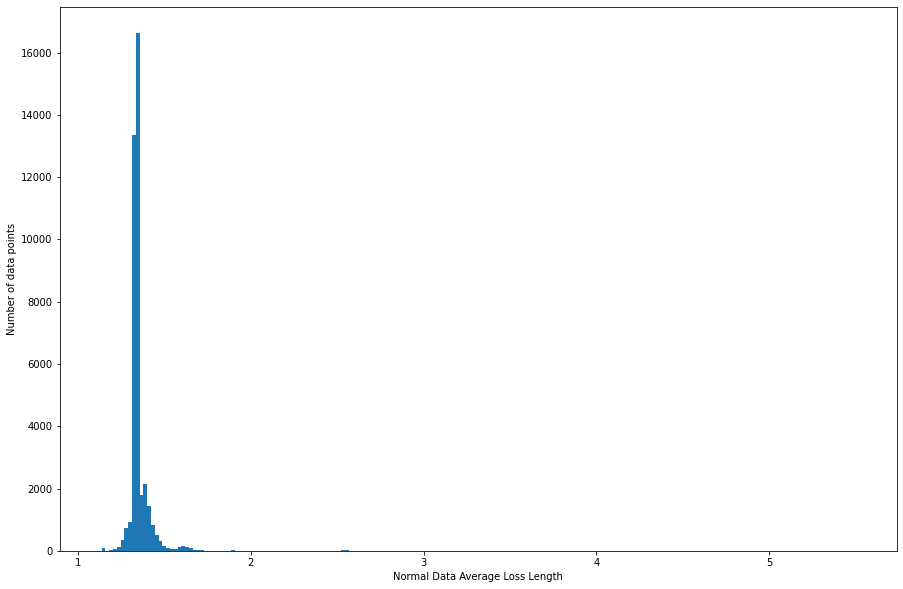

In [61]:
normal_data=df[df["Class"]==0].drop("Class",axis=1)
y_pred=autoecoder.predict(normal_data)
y_dist=np.linalg.norm(normal_data-y_pred,axis=-1)

plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Normal Data Average Loss Length")
plt.ylabel("Number of data points")
plt.show()

### View the avrage length distribution of anomalie data

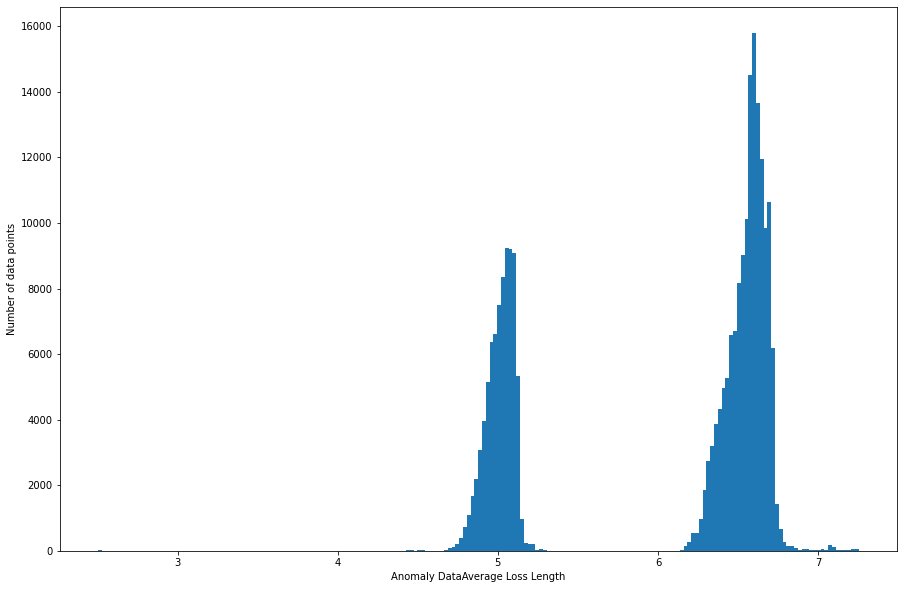

In [62]:
anomalie_data=df[df["Class"]==1].drop("Class",axis=1)
y_pred=autoecoder.predict(anomalie_data)  
y_dist=np.linalg.norm(anomalie_data-y_pred,axis=-1) 
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

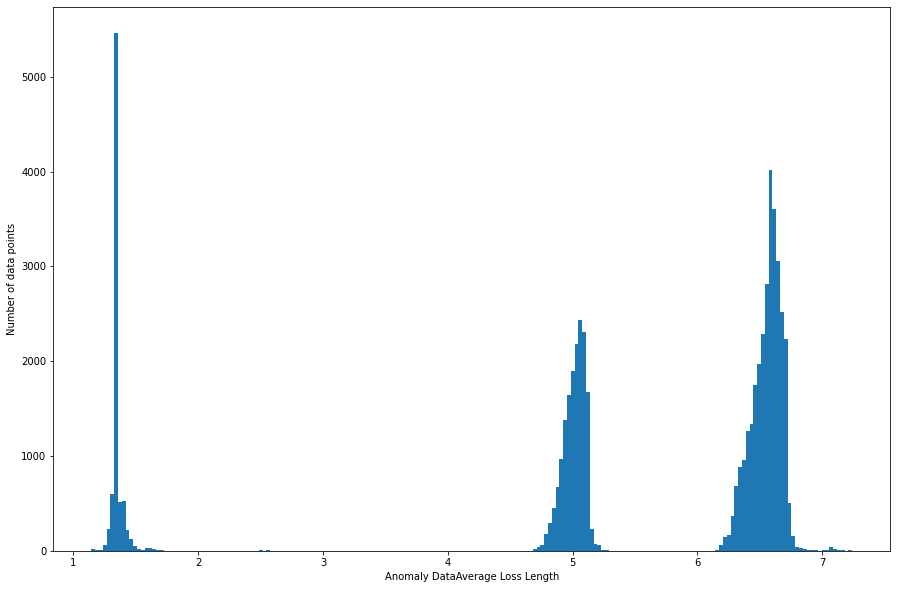

In [63]:
y_pred=autoecoder.predict(xtest) # predict new data 
y_dist=np.linalg.norm(xtest-y_pred,axis=-1) # calculate distance between real  and predicted data
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

## we see that all the anamalies data are more then 1.5 average length loss
## as a conclusion we will make the 1.5 as our average loss threshold

In [81]:
def prediction(xtest):
    threshold=2.8 
    start_time = time.time() 
    y_pred=autoecoder.predict(xtest) 
    print("--- %s seconds ---" % (time.time() - start_time))    
    y_dist=np.linalg.norm(xtest-y_pred,axis=-1) 
    z=zip(y_dist >= threshold , y_dist) 
    y_label=[]
    error=[]
    for idx ,(is_anomaly , y_dist) in enumerate(z):
        if is_anomaly : # if the value is True : which mean the distance is sup then the threshold 
            y_label.append(1)
        else:
            y_label.append(0)
        error.append(y_dist)
    return y_label

In [82]:
y_pred=prediction(xtest)

--- 0.574420690536499 seconds ---


In [83]:
print(sklearn.metrics.classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8004
           1       1.00      1.00      1.00     47608

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [84]:
ytest = ytest.astype(int)
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) 
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9997122566015973
accuracy_score : 0.999712292311012
recall_score : 0.999712292311012
f1_score : 0.9997122324696014
roc_auc_score : 0.9992083650663326
True_positive : 47604, False_positive : 12, True_negative : 7992, False_negative : 4


In [85]:
viz=Visualization()

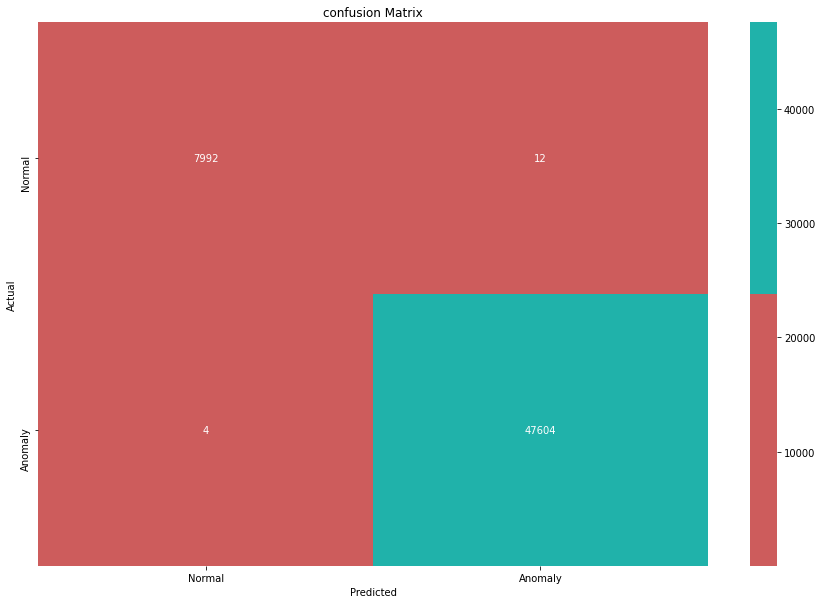

In [86]:
viz.drow_confusion_matrix(ytest,y_pred)

In [87]:
autoecoder.save("./models/ae.h5")